# Workflow for Designing Closed Loop Systems

This notebook explores the construction of closed loop systems for SBML models to elucidate the workflow.

State Feedback Architecture (without disturbance and noise)

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_24-Testbed-for-Full-State-Feedback/Full-State-Feedback.png?raw=true"
alt="Markdown Monster icon"
width=500pt
style="float: left; margin-right: 10px;" />

This notebook describes how to build state feedback.

# Preliminaries

## Imports

In [1]:
!pip install -q control
!pip install -q tellurium
!pip install -q controlSBML

import control
import controlSBML as ctl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tellurium as te

## Constants

In [2]:
TIMES = ctl.makeSimulationTimes(0, 5, 500)
SYSTEM = "system"
CONTROLLER = "controller"
CONTROLLER_IN = "controller.in"
CONTROLLER_REF = "controller.ref"
CONTROLLER_OUT = "controller.out"
SIGNAL_SUM = "signal_sum"
SIGNAL_SUM_IN1 = "signal_sum.in1"
SIGNAL_SUM_IN2 = "signal_sum.in2"
SIGNAL_SUM_OUT = "signal_sum.out"

In [3]:
BIOMD823 = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000823.2?filename=Varusai2018.xml"
BIOMD206 = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml"

# Antimony Model

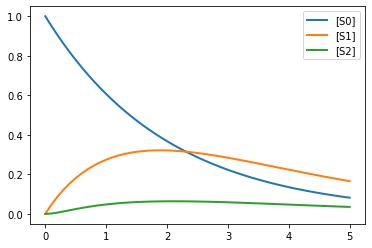

In [4]:
ANT_MODEL = """
S0 -> S1; k0*S0
S1 -> S2; k1*S1
S2 -> S1; k2*S2
S2 -> ; k3*S2

S0 = 0
S1 = 0
S2 = 0
S3 = 0
k0 = 0.5
k1 = 1
k2 = 2
k3 = 3
"""
rr = te.loada(ANT_MODEL)
rr["S0"] = 1
rr.simulate()
rr.plot()

# Model of Glycoytic Oscillations (BioModels 206)

**Reactions in Glycolytic Oscillations**

``at`` is ``ATP``; ``s5`` is ``pyruvate``.

    v1: s1 + 2 at_ -> s2; compartment_*k1*s1*at_/(1 + (at_/ki)^n);
    v2: s2 -> 2 s3; compartment_*k2*s2;
    v3: s3 + na -> s4 + at_;compartment_*((k31*k32*s3*na*(atot - at_) 
        - k33*k34*s4*at_*(ntot - na))/(k33*(ntot - na) + k32*(atot - at_)));
    v4: s4 -> s5 + at_; compartment_*k4*s4*(atot - at_);
    v5: s5 -> s6; compartment_*k5*s5;
    v7: at_ -> ; compartment_*k7*at_;
    v8: s3 -> na; compartment_*k8*s3*(ntot - na);
    v9: s6o -> ; compartment_*k9*s6o;
    v10: s6 -> 0.1 s6o; compartment_*k10*(s6 - s6o);
    v6: s6 -> na; compartment_*k6*s6*(ntot - na);
    v0:  -> s1; compartment_*k0;

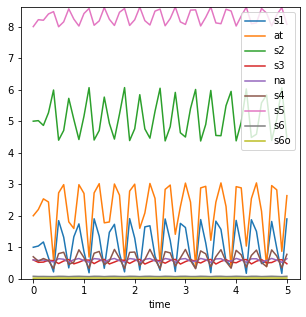

In [5]:
ctlsb = ctl.ControlSBML(BIOMD206)
ctlsb.plotTrueModel(figsize=(5,5))

## Controller Factory

In [6]:
def makeController(name, kp=2):
    """
    Creates a proportional controller as a NonlinearIOSystem with input "in" and output "out".
    
    Parameters
    ----------
    name: str
        Name of the system
    kp: float
    
    Returns
    -------
    control.NonlinearIOSystem
    """
    def outfcn(_, __, u_vec, ___):
        # u: float (error signal)
        if not "len" in dir(u_vec):
            u_vec = [u_vec]
        return kp*(u_vec[0])
    #
    return control.NonlinearIOSystem(
        None, outfcn, inputs=['in'], outputs=['out'],
        name=name)

# Tests
kp = 2
controller = makeController("controller", kp=kp)
times = [0, 1, 2, 3, 4]
result = control.input_output_response(controller, T=times, U=times)
trues = [r == kp*( t) for t, r in zip(result.t, result.outputs)]
assert(all(trues))
print("OK!")

OK!


## Testbed

In [7]:
# Elements of the system
factory = ctl.IOSystemFactory()
kp = 0.01
input_name = "at"
output_name = "s5"
# Create the elements of the feedback loop
ctlsb = ctl.ControlSBML(BIOMD206, input_names=[input_name], output_names=[output_name])
system = ctlsb.makeNonlinearIOSystem("system")
controller = makeController("controller", kp=kp)
sum_R_S = factory.makeAdder("sum_R_S")

In [8]:
# Create the closed loop system
system_in = "system.%s" % input_name
system_out = "system.%s" % output_name
closed_loop = control.interconnect(
  [sum_R_S, system, controller ], 
  connections=[
    ['controller.in', 'sum_R_S.out'],    # e(t)
    [system_in,   'controller.out'],   # u(t)
    ['sum_R_S.in1', "-" + system_out],
  ],
  inplist=["sum_R_S.in2"],
  outlist=["sum_R_S.in2", system_in, system_out],
)

## Simulation

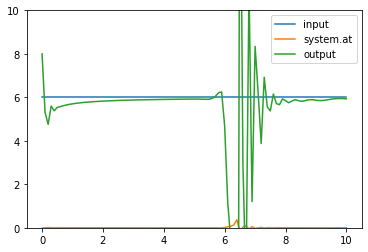

In [9]:
X0 = ctl.makeStateVector(closed_loop)
times = ctl.makeSimulationTimes(0, 10, 10)
# Need the initial state
result = control.input_output_response(closed_loop, T=times, U=6, X0=X0)
plt.plot(result.t, result.outputs[0].flatten())
plt.plot(result.t, result.outputs[1].flatten())
plt.plot(result.t, result.outputs[2].flatten())
#plt.plot(result.t, result.outputs[3].flatten())
plt.ylim([0, 10])
legends = ["input", system_in, "output"]
plt.legend(legends)

# Scripting the Full State Controller

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_24-Testbed-for-Full-State-Feedback/Full-State-Feedback.png?raw=true"
alt="Markdown Monster icon"
width=500pt
style="float: left; margin-right: 10px;" />

## Controller Interface

* Inputs: $r(t)$, ${\bf x}(t)$
* Outputs: $u(t)$

## Calculating ${\bf k_P}$

Given desired poles, $\lambda_1, \cdots, \lambda_n$, find
$[k_{p1}, \cdots, k_{pn}] = {\bf k_P}$

In [10]:
ctlsb = ctl.ControlSBML(ANT_MODEL, input_names=["S0"], output_names=["S2"])

 We want to use control.place(A, B, p) to place poles.

In [11]:
state_space = ctlsb.makeStateSpace()
state_space.A, state_space.B

(array([[-1.,  2.],
        [ 1., -5.]]),
 array([[0.5],
        [0. ]]))

In [12]:
control.place(state_space.A, state_space.B, [-3, -4])

array([[2., 8.]])

Inputs to the controller factory
* name
* desired poles
* ControlSBML object

## Implementation

In [13]:
print(ctlsb.antimony)

// Created by libAntimony v2.12.0
// Compartments and Species:
species S0, S1, S2;

// Reactions:
_J0: S0 -> S1; k0*S0;
_J1: S1 -> S2; k1*S1;
_J2: S2 -> S1; k2*S2;
_J3: S2 -> ; k3*S2;

// Species initializations:
S0 = 0;
S1 = 0;
S2 = 0;

// Variable initializations:
k0 = 0.5;
k1 = 1;
k2 = 2;
k3 = 3;
S3 = 0;

// Other declarations:
const k0, k1, k2, k3, S3;



In [14]:
# Scripting the full state controller. Do in a generic way.
#### INPUTS
name = "controller"
pole = -2 # Dominant pole
ctlsb = ctl.ControlSBML(BIOMD823, input_names=["pAkt"], output_names=[ "DEPTOR"])
ctlsb = ctl.ControlSBML(BIOMD206, input_names=["at"], output_names=[ "s5"])
ctlsb = ctl.ControlSBML(ANT_MODEL, input_names=["S0"], output_names=[ "S2"])
#### BODY
# Get the names of the internal states of the system
states = ["%s" % n for n in ctlsb.state_names
          if not n in ctlsb.input_names]
num_state = len(states)
state_space = ctlsb.makeStateSpace()
poles = np.array([pole-0.1*n for n in range(num_state)])
kP = control.place(state_space.A, state_space.B, poles)
kP = np.reshape(kP, num_state)
#
def outfcn(time, _, u_vec, __):
    # u_vec[0] - reference
    # u_vec[1:] - system state
    # kp: column vector
    ref = u_vec[0]
    arr = list(u_vec[1:])
    arr = np.reshape(np.array(arr), num_state)
    output = ref - arr.dot(kP)
    return output
# Construct the NonlinearIOSystem
inputs = list(states)
inputs.insert(0, "ref")
controller = control.NonlinearIOSystem(
    None, outfcn, inputs=inputs, outputs=['out'],
    name=name)
# Return
#### RETURN controller

In [15]:
np.linalg.matrix_rank(state_space.A)

2

In [16]:
# Tests
num_input = ctlsb.num_state  # Exclude input state; add 'ref'
assert(controller.ninputs == num_input)
# Can simulate
U = np.repeat(1, num_input)
U = np.reshape(U, (num_input, 1))
result = control.input_output_response(controller, [1], U=U)
assert(len(result.y.flatten()) == 1)

# Factory for Full State Controller

In [17]:
def makeFullStateController(name, pole, ctlsb, dcgain=1):
    """
    Description:

    Parameters
    ----------
    name: str
        Name of the controller
    pole: float
        Dominant pole
    ctlsb: ControlSBML

    Returns
    -------
    control.NonlinearIOSystem
    """
    # Get the names of the internal states of the system
    states = ["%s" % n for n in ctlsb.state_names
              if not n in ctlsb.input_names]
    num_state = len(states)
    state_space = ctlsb.makeStateSpace()
    poles = np.array([pole-0.1*n for n in range(num_state)])
    kP = control.place(state_space.A, state_space.B, poles)
    kP = np.reshape(kP, num_state)
    #
    def outfcn(time, _, u_vec, __):
        # u_vec[0] - reference
        # u_vec[1:] - system state
        # kp: column vector
        ref = u_vec[0]
        arr = list(u_vec[1:])
        arr = np.reshape(np.array(arr), num_state)
        output = ref/dcgain - arr.dot(kP)
        return output
    # Construct the NonlinearIOSystem
    inputs = list(states)
    inputs.insert(0, "ref")
    controller = control.NonlinearIOSystem(
        None, outfcn, inputs=inputs, outputs=['out'],
        name=name)
    #
    return controller

# Tests
name = "controller"
pole = -2 # Dominant pole
#ctlsb = ctl.ControlSBML(BIOMD823, input_names=["pAkt"], output_names=[ "DEPTOR"])
#ctlsb = ctl.ControlSBML(BIOMD206, input_names=["at"], output_names=[ "s5"])
ctlsb = ctl.ControlSBML(ANT_MODEL, input_names=["S0"], output_names=[ "S2"])
controller = makeFullStateController(name, pole, ctlsb)
#### BODY
num_input = ctlsb.num_state  # Exclude input state; add 'ref'
assert(controller.ninputs == num_input)
# Can simulate
U = np.repeat(1, num_input)
U = np.reshape(U, (num_input, 1))
result = control.input_output_response(controller, [1], U=U)
assert(len(result.y.flatten()) == 1)

# Testbed

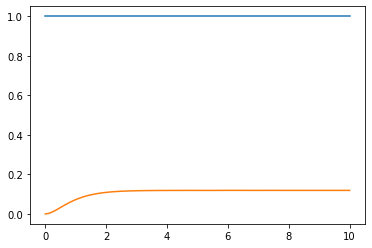

In [18]:
#### INPUTS
input_name = "S0"
output_name = "S2"
pole = -2
ref = 1
model = ANT_MODEL
#### BODY
# Find the list of states within the system under control & and contruct system to control
ctlsb = ctl.ControlSBML(model, input_names=[input_name], output_names=[output_name])
state_names = ["%s" % n for n in ctlsb.state_names
            if not n in ctlsb.input_names]
ctlsb = ctl.ControlSBML(model, input_names=[input_name], output_names=state_names)
# Create the components of the closed loop system
system = ctlsb.makeNonlinearIOSystem("system")
system_in = "system.%s" % input_name
controller = makeFullStateController("controller", pole, ctlsb)
# Create the connections
connections = []
for name in state_names:
    new_connection = ["controller." + name, "system." + name]
    connections.append(new_connection)
connections.append([system_in,   'controller.out'])
# Construct the closed loop system
cl_out = "system.%s" % output_name
cl_in = "controller.ref"
closed_loop = control.interconnect(
  [system, controller ], 
  connections=connections,
  inplist=[cl_in],
  outlist=[ cl_out]
)
# Simulate and plot
times = ctl.makeSimulationTimes(end_time=10)
X0 = ctl.makeStateVector(closed_loop)
result = control.input_output_response(closed_loop, times, U=ref, X0=X0)
plt.plot([times[0], times[-1]], [ref, ref])
plt.plot(times, result.y[0])

# Adjusting for DC Gain

In [19]:
cl_state_space = closed_loop.linearize(X0, 1)
tf = control.ss2tf(cl_state_space)
#tf = control.TransferFunction(tf_vec.num[1][0], tf_vec.den[1][0])
tf

TransferFunction(array([0.5]), array([1. , 4.1, 4.2]))

In [20]:
tf.dcgain()

0.1190476190344021

# Evaluation Environment

In [21]:
def evaluateFullStateController(model, input_name, output_name, pole=-2, ref=1, end_time=10):
    """
    Evaluates full state control for the model for the specified dominant pole. Evaluates w.r.t. to the ref input.
    
    Parameters
    ----------
    model: str
    input_name: str
    output_name: str
    pole: float
    end_time: float
    """